In [1]:
import os, shutil
import tensorflow as tf




In [2]:
original_dataset_dir = '/floyd/input/skin_disease_dataset/train'

In [3]:
os.listdir('/floyd/input/skin_disease_dataset/train')

['Vascular Tumors',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Light Diseases and Disorders of Pigmentation',
 'Warts Molluscum and other Viral Infections',
 'Nail Fungus and other Nail Disease',
 'Bullous Disease Photos',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Eczema Photos',
 'Seborrheic Keratoses and other Benign Tumors',
 'Lupus and other Connective Tissue diseases',
 'Systemic Disease',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Vasculitis Photos',
 'Herpes HPV and other STDs Photos',
 'Acne and Rosacea Photos',
 'Urticaria Hives',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Exanthems and Drug Eruptions',
 'Atopic Dermatitis Photos']

In [4]:
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

In [6]:
img_width, img_height = 224, 224

In [7]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [8]:
res = preprocess_image("/floyd/input/skin_disease_dataset/train/Acne and Rosacea Photos/07Acne081101.jpg")
print(res)

[[[[   8.060997     4.2210007   31.32     ]
   [  15.060997     8.221001    36.32     ]
   [  18.060997     9.221001    37.32     ]
   ...
   [   2.060997    -3.7789993   28.32     ]
   [   5.060997    -0.7789993   31.32     ]
   [   4.060997    -1.7789993   30.32     ]]

  [[  15.060997    11.221001    38.32     ]
   [  18.060997    11.221001    39.32     ]
   [  20.060997    11.221001    39.32     ]
   ...
   [ -13.939003   -19.779       12.32     ]
   [   9.060997     1.2210007   33.32     ]
   [  17.060997    10.221001    40.32     ]]

  [[  13.060997     9.221001    36.32     ]
   [  13.060997     6.2210007   34.32     ]
   [  17.060997     8.221001    36.32     ]
   ...
   [  19.060997    11.221001    43.32     ]
   [  22.060997    12.221001    43.32     ]
   [   7.060997    -2.7789993   28.32     ]]

  ...

  [[   7.060997     3.2210007   33.32     ]
   [   8.060997     4.2210007   31.32     ]
   [  21.060997    13.221001    39.32     ]
   ...
   [-100.939     -110.779     -113.

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

HEIGHT = 224
WIDTH = 224

base_model = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/floyd/input/skin_disease_dataset/train"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        '/floyd/input/skin_disease_dataset/test',
        target_size=(224, 224),
        batch_size=BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [11]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = os.listdir("/floyd/input/skin_disease_dataset/train")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [12]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 170
BATCH_SIZE = 20
num_train_images = 15557

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(
    k=5, name='top_5'), tf.keras.metrics.TopKCategoricalAccuracy(
    k=3, name='top_3')])


checkpoint = ModelCheckpoint("inception-v3.h5", monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history1 = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=(validation_generator),
                             workers=16, 
                             steps_per_epoch=num_train_images // BATCH_SIZE,
                             validation_steps = num_train_images // BATCH_SIZE, shuffle=True, callbacks=callbacks_list)

Epoch 1/170
777/777 [==============================] - ETA: 0s - loss: 3.2621 - accuracy: 0.1059 - top_5: 0.3602 - top_3: 0.2449
Epoch 00001: saving model to inception-v3.h5
777/777 [==============================] - 69s 89ms/step - loss: 3.2621 - accuracy: 0.1059 - top_5: 0.3602 - top_3: 0.2449 - val_loss: 2.8713 - val_accuracy: 0.1530 - val_top_5: 0.4675 - val_top_3: 0.3343
Epoch 2/170
777/777 [==============================] - ETA: 0s - loss: 2.9732 - accuracy: 0.1398 - top_5: 0.4133 - top_3: 0.2949
Epoch 00002: saving model to inception-v3.h5
777/777 [==============================] - 70s 90ms/step - loss: 2.9732 - accuracy: 0.1398 - top_5: 0.4133 - top_3: 0.2949 - val_loss: 2.7909 - val_accuracy: 0.1941 - val_top_5: 0.5309 - val_top_3: 0.3902
Epoch 3/170
776/777 [============================>.] - ETA: 0s - loss: 2.8817 - accuracy: 0.1628 - top_5: 0.4630 - top_3: 0.3354
Epoch 00003: saving model to inception-v3.h5
777/777 [==============================] - 70s 90ms/step - loss: 2.8

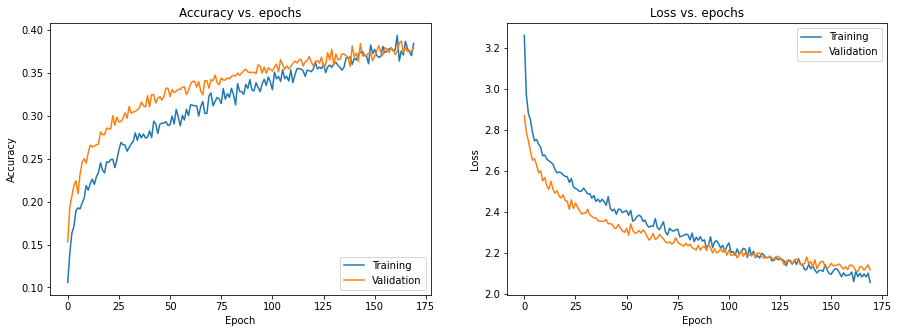

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
except KeyError:
    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = finetune_model.predict_generator(validation_generator, num_train_images // 31)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
matrix = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
import seaborn as sns 
p = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix', y=1.1)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')